In [1]:
import os
os.environ["LOGURU_LEVEL"] = "INFO"
import fsspec
import tqdm

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats import wasserstein_distance, gaussian_kde
from scipy.spatial.distance import jensenshannon

from mood.splitter import MOODSplitter, SplitCharacterization
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.utils import load_distances_for_downstream_application
from mood.visualize import axes_grid_iterator

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SUBDIR = "20221219"

In [3]:
PATTERN = dm.fs.join("gs://experiments-output/mood-v2/results/numpy/compare_splits", SUBDIR, "*.npy")

In [4]:
paths = dm.fs.glob(PATTERN)
paths[:3]

['gcs://experiments-output/mood-v2/results/numpy/compare_splits/20221219/distances_BBB_ChemBERTa_Maximum Dissimilarity.npy',
 'gcs://experiments-output/mood-v2/results/numpy/compare_splits/20221219/distances_BBB_ChemBERTa_Perimeter.npy',
 'gcs://experiments-output/mood-v2/results/numpy/compare_splits/20221219/distances_BBB_ChemBERTa_Random.npy']

In [5]:
data = defaultdict(lambda: defaultdict(list))

for path in tqdm.tqdm(paths): 
    basename = dm.fs.get_basename(path)
    basename = os.path.splitext(basename)[0]
    _, dataset, representation, label = basename.split("_")
    with fsspec.open(path, "rb") as fd:
        distances = np.load(fd)
        
    data[dataset][representation].append(SplitCharacterization(distances, None, label))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:04<00:00,  4.09it/s]


In [6]:
cmap = sns.color_palette("rocket", 5)
cmap

[(0.24525608, 0.10497384, 0.26395596),
 (0.51728314, 0.1179558, 0.35453252),
 (0.7965014, 0.10506637, 0.31063031),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96443322, 0.67025402, 0.51509334)]

Text(0.5, 1.025, 'Visualization of the MOOD test split protocol')

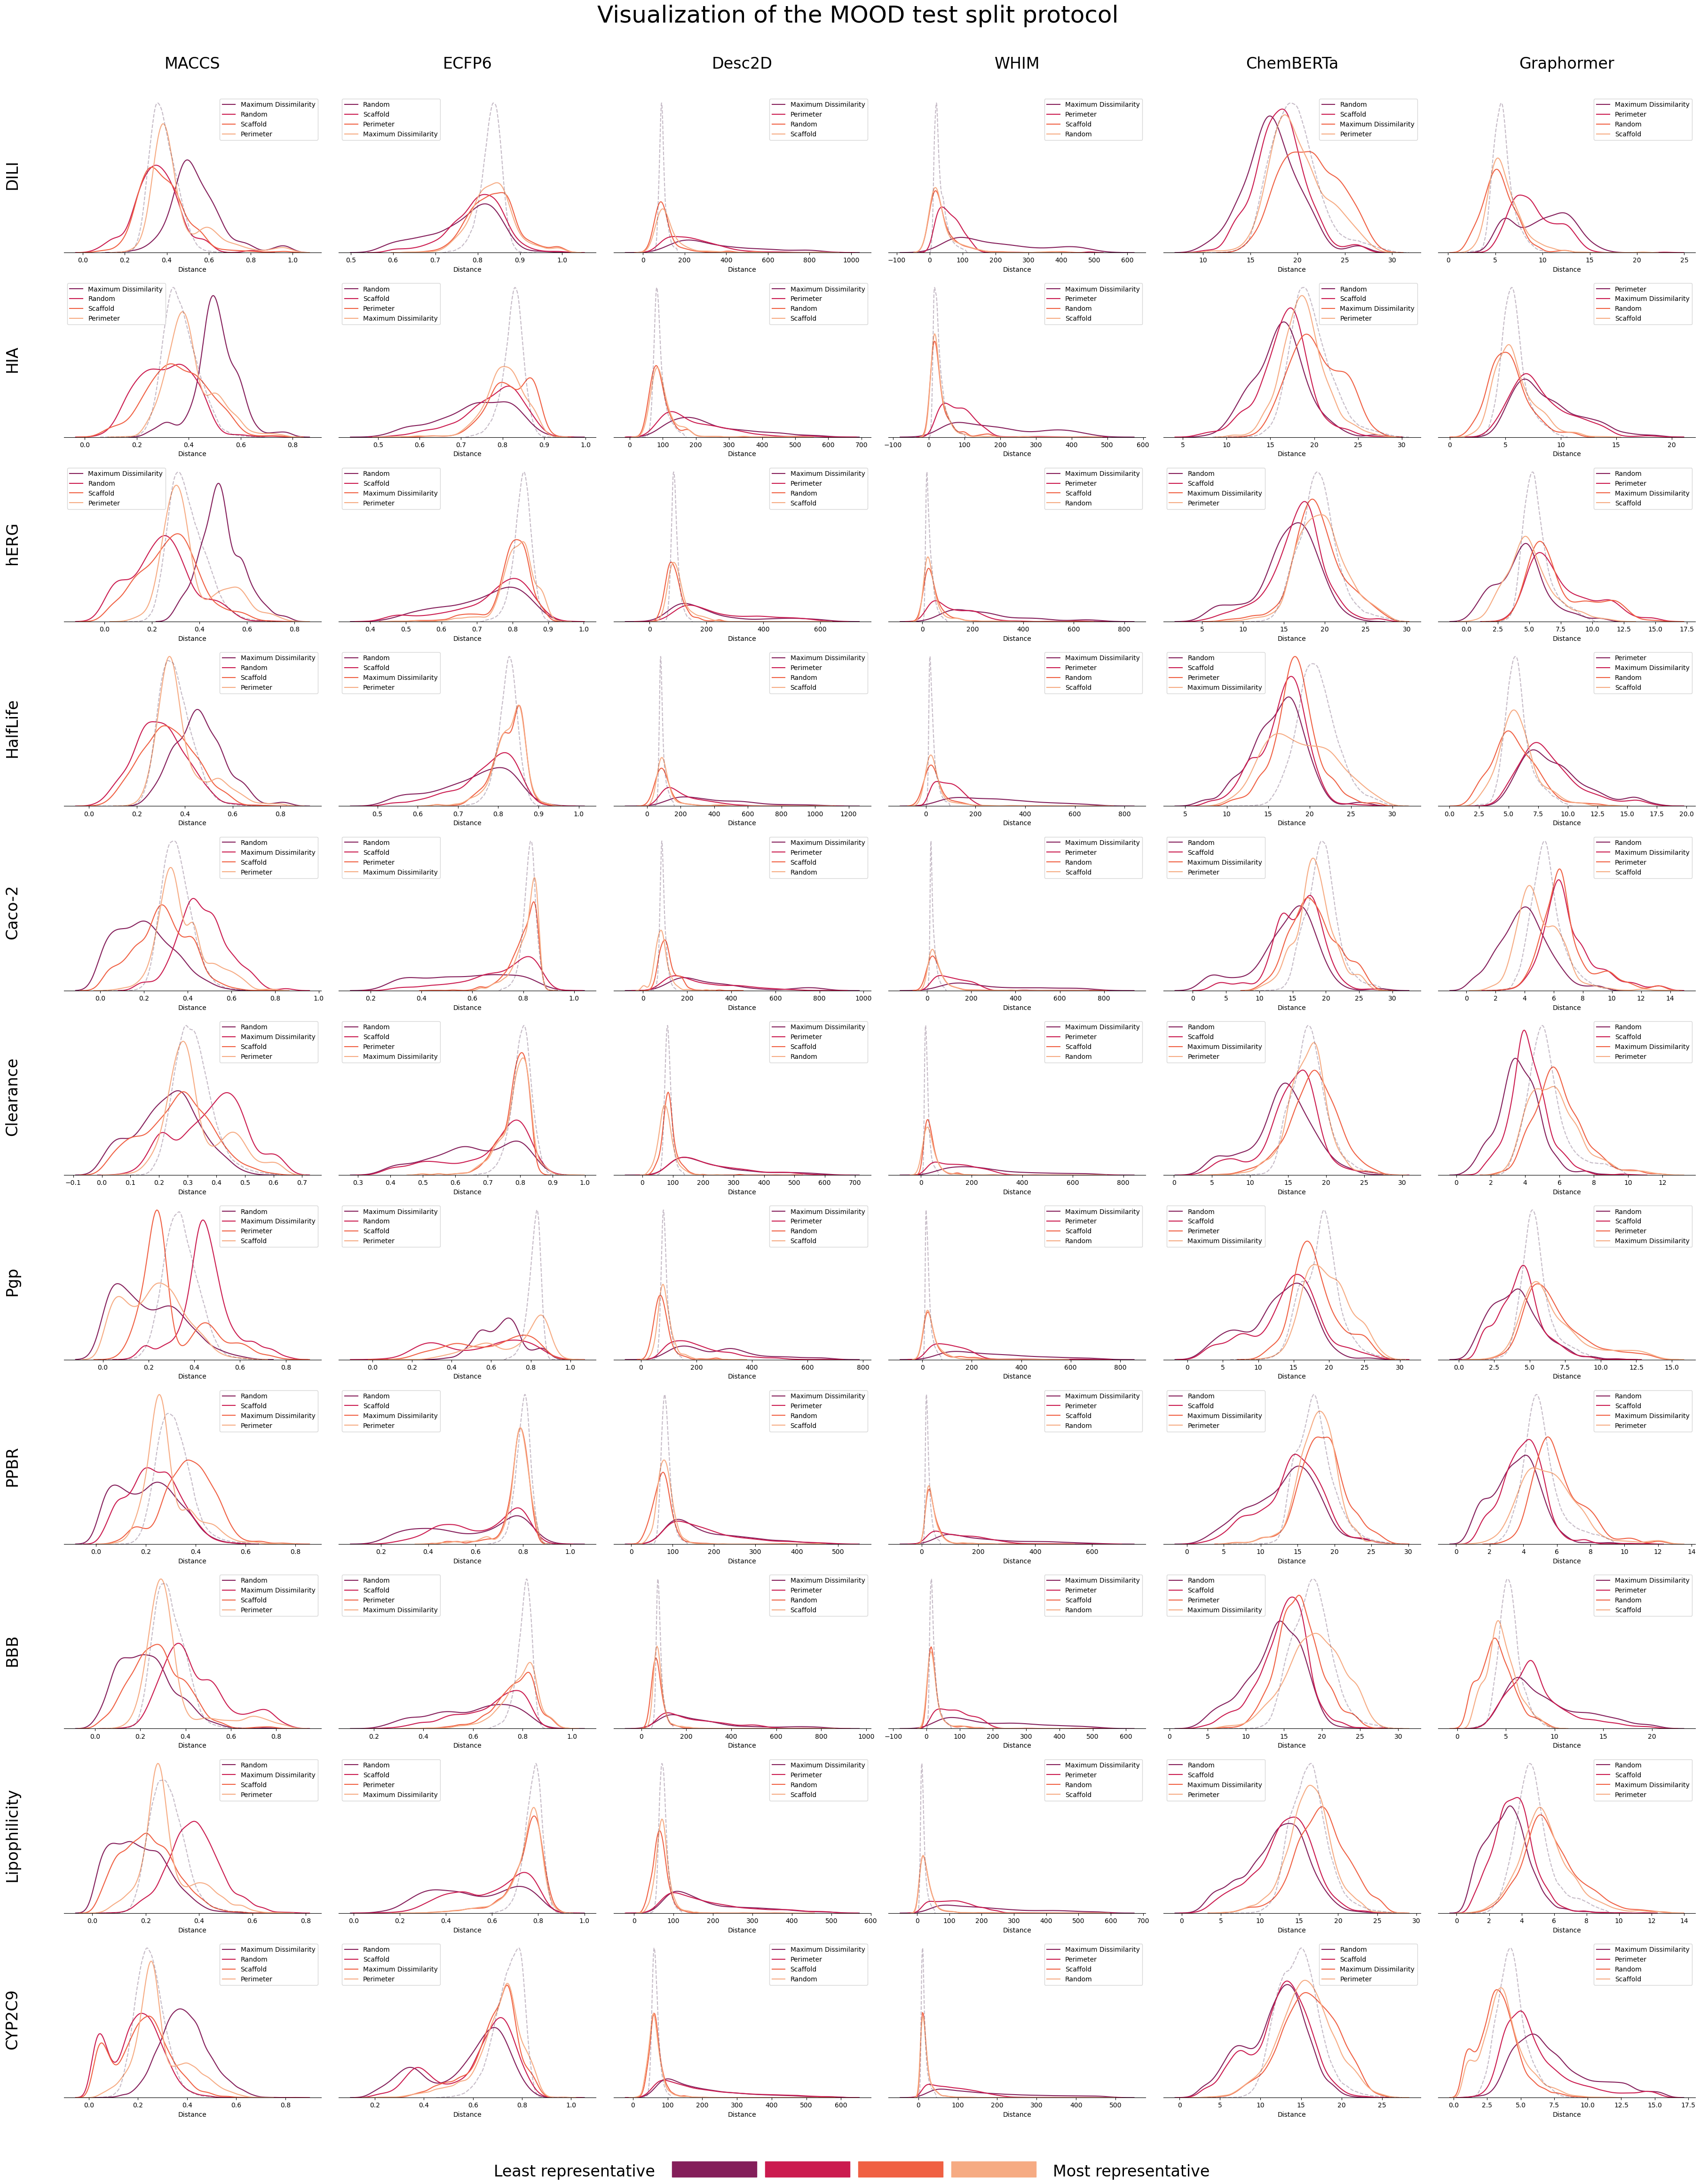

In [7]:
representations = MOOD_REPRESENTATIONS
datasets = MOOD_DATASETS

iterator = axes_grid_iterator(
    col_labels=representations, 
    row_labels=datasets,
    col_size=6, 
    row_size=4,
    margin=0.2,
)
    
for ax, ri, ci in iterator:
        
    dataset = datasets[ri]
    representation = representations[ci]
    
    if len(data[dataset][representation]) == 0: 
        ax.axis("off")
        continue
    
    # NOTE: Be aware that by default, it will reuse the distance that are cached. 
    #  If you updated this file remotely, you should set `update_cache=True`
    distances_vs = load_distances_for_downstream_application(
        "virtual_screening", representation, dataset,
    )
    distances_op = load_distances_for_downstream_application(
        "optimization", representation, dataset,
    )
        
    downstream_distances = np.concatenate([distances_vs, distances_op])
        
    for char in data[dataset][representation]:
        
        char.representativeness = MOODSplitter.score_representativeness(
            downstream_distances, char.distances
        )
        
    MOODSplitter.visualize(downstream_distances, data[dataset][representation], ax=ax)

    
plt.tight_layout()

fig = plt.gcf()

rectangle_width = 0.05
rectangle_height = 0.0075
rectangle_margin = 0.005
n_rectangles = 4

x_step = rectangle_width + rectangle_margin
x0 = 0.5 - (x_step * n_rectangles) / 2
y0 = -0.025

fig.patches.extend([
    plt.Rectangle(
        (x0 + (i * x_step), y0), 
        rectangle_width,
        rectangle_height, 
        fill=True, 
        color=cmap[i + 1], 
        zorder=1000,
        transform=fig.transFigure, 
        figure=fig
    ) for i in range(4)]
)

plt.text(x0 - rectangle_margin * 2, -0.0225, "Least representative", transform=fig.transFigure, ha="right", va="center", fontsize=24)
plt.text(x0 + 4 * x_step + rectangle_margin, -0.0225, "Most representative", transform=fig.transFigure, ha="left", va="center", fontsize=24);
plt.gcf().suptitle(f"Visualization of the MOOD test split protocol", fontsize=36, y=1.025)

The End. 